In [1]:
#!/usr/bin/python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import pandas as pd

In [2]:
sys.path.append('../python/')
import tools
import scrapers
import models
import plotting
savePath="../figures/"

# Read in and prepare data

In [3]:
# read in pre-scraped player data 
startSeason = 1980
endSeason   = 2019
nSeasons    = endSeason - startSeason + 1
dfDict      = {}
for season in np.arange(endSeason, startSeason-1, -1):
    inPath   = "../data/players/"+str(season)+"/"
    fileList = os.listdir(inPath)
    for fileName in fileList:
        playerId = fileName[:-4]
        if playerId not in list(dfDict.keys()):
            df               = pd.read_csv(inPath + fileName)
            dfDict[playerId] = df
print("read in data for " + str(len(dfDict)) + " unique players from between " 
      + str(startSeason) + " and " + str(endSeason))

read in data for 2825 unique players from between 1980 and 2019


In [4]:
# assemble the original features in numpy array
featureList    = ["PTS","MP","2P%","2PA","3P%","3PA","FT%","FTA","ORB","DRB","AST","TOV","STL","BLK","PF"]
idList, npData = models.dict_to_np_players(dfDict, featureList)
npData         = models.scale_features(npData)
print("created np array with shape " + str(npData.shape))

created np array with shape (13215, 15)


# Feature Selection and Dimensionality Reduction
The initial features have blatant redudancies, as well as more subtle redundancies.  
I use a PCA analysis to select the most meaningful features while reducing dimensionality.  
I choose to keep enough features to describe 90% of the variance of the original data.  

In [5]:
# fit pca and transform data into new vector space
pca, npDataTrans = models.fit_pca(npData, 0.90)
nTot, nFeatures = npDataTrans.shape

Using 7 components explaining 92.04313537860574% of variance in original data set


# K-Means Clustering
Here I perform a clustering classification in the new vector space, classifying each player's year-end stats for each season they played.  
In order to determine the appropriate number of clusters, I fit several choices for nClusters, measure the total distance from each point to it's cluster center, and plot these distances on an "elbow plot".  

In [6]:
# run a series of kmeans classifications with different nClusters
nClusterList = range(1,20)
distSumsList = []
for nClusters in nClusterList:
    # run the alg in the new feature space from the pca
    kmeans = KMeans(n_clusters=nClusters)
    kmeans.fit(npDataTrans)
    # measure the sum of the distances to cluster centers for each kmeans
    totDist = np.sqrt(models.tot_sum_cluster_dists2(npDataTrans, kmeans))
    distSumsList.append(totDist)

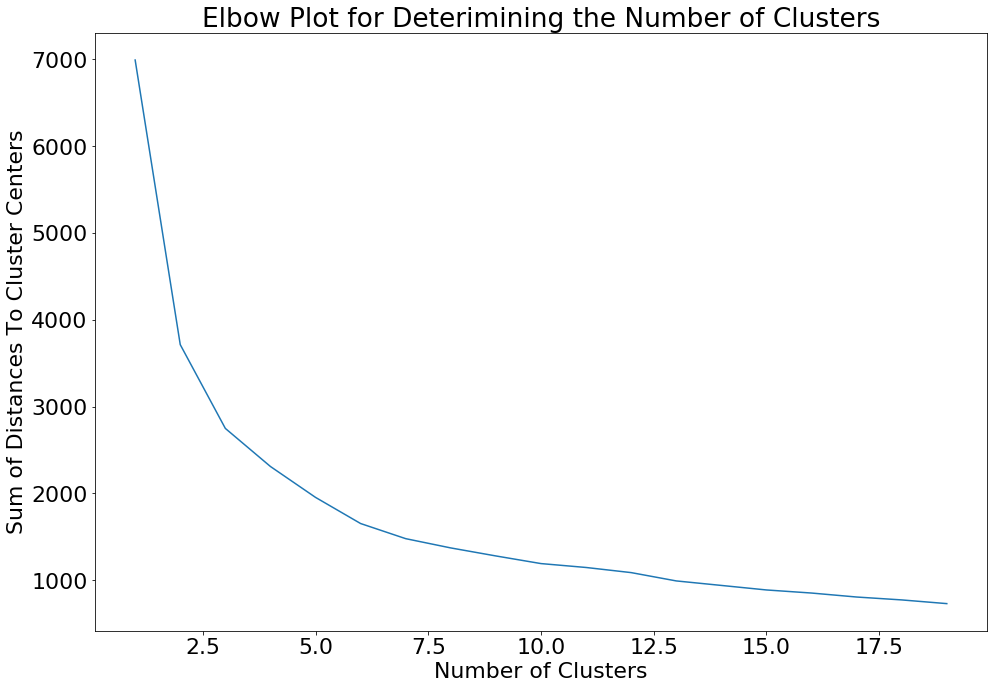

In [7]:
# make an elbow plot to determine the appropriate number of clusters
plt.plot(nClusterList, distSumsList)
plt.ylabel("Sum of Distances To Cluster Centers")
plt.xlabel("Number of Clusters")
plt.title("Elbow Plot for Deterimining the Number of Clusters");

In [8]:
# Use the plot above to select nClusters and do a final kmeans with that parameter
nClusters = 6
kmeans = KMeans(n_clusters=nClusters)
kmeans.fit(npDataTrans);

# Finding Representative Players
This is just bookkeeping, but it will be helpful to label each cluster with a single "archetype" player that I can use to refer to the cluster, rather than just calling them cluster "0, 1, 2" etc.  
Here, I find the n closest players to each cluster center and pick one to be the archetype.  

In [9]:
# List players/seasons closest to cluster centers to find representative players for each cluster
for n in range(nClusters):
    theseIds, sortedDists = models.get_sorted_distances(kmeans.cluster_centers_[n], idList, npDataTrans, 50)
    print(n)
    print(theseIds)
    print("\n")

0
['rothsc_1989', 'rothsc_1989', 'rothsc_1989', 'bardost_1993', 'owensan_2006', 'gamblke_1989', 'baileto_2000', 'baileto_1999', 'goodwar_2014', 'johnsni_2015', 'pattela_2017', 'wellsbu_1998', 'templga_2014', 'nichoan_2017', 'nichoan_2017', 'nichoan_2017', 'fontais_2002', 'porteot_2014', 'rothsc_1988', 'balkmre_2012', 'swanica_2019', 'swanica_2019', 'swanica_2019', 'goodedr_2013', 'wingada_1995', 'savovpr_2003', 'taylodo_2006', 'swanica_2018', 'keysra_1989', 'ndourma_2017', 'milesda_2009', 'phelpmi_1987', 'martima_1987', 'blankla_1993', 'buechju_1991', 'simpkdi_1997', 'randama_1992', 'randama_1992', 'randama_1992', 'battito_2010', 'collima_2010', 'weberbr_2017', 'weberbr_2017', 'weberbr_2017', 'judkije_1982', 'hassetr_2008', 'hassetr_2008', 'hassetr_2008', 'wroteto_2013', 'brunsri_2000']


1
['oladivi_2015', 'jacksji_1998', 'jacksji_1998', 'jacksji_1998', 'davisri_2006', 'davisri_2006', 'davisri_2006', 'sprewla_2001', 'scottby_1988', 'bledser_2014', 'evansty_2011', 'cassesa_2002', 'bled

In [10]:
repPlayers = ["Garret Temple 2015 SF/SG", 
              "Victor Oladipo 2015 SG/PG", 
              "Nikola Vucevic 2016 C",
              "Leandro Barbosa 2016 SG/PG", 
              "Adreian Payne 2015 PF", 
              "JR Smith 2011 SG"]

# Visualize the Clustering Analysis
Here I make a 2D scatter plot showing the results of the clustering analysis in the first two PCs.  
I add some labels showing where a selection of players lie in this somewhat abstract vector space.

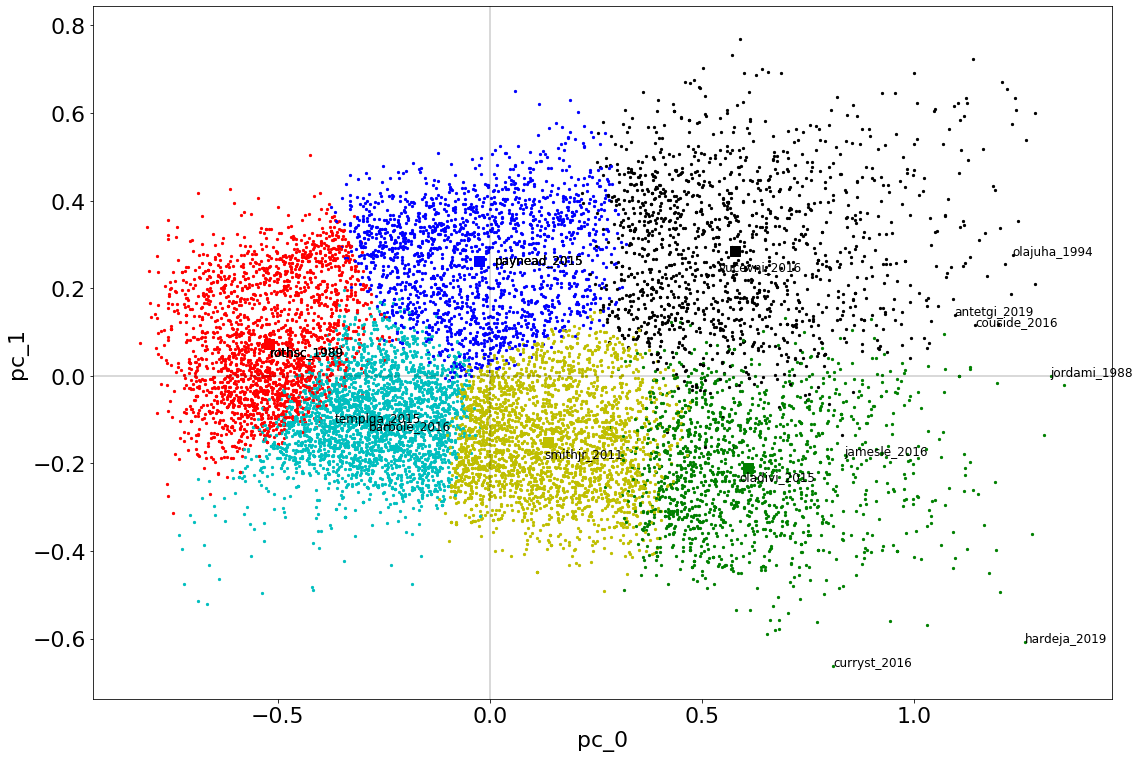

In [83]:
# scatter plots showing clustering in first 2 PCA components
plt = plotting.scatter_2d(kmeans, npDataTrans)
playersToLabel =[
"curryst_2016", "jamesle_2016","hardeja_2019","antetgi_2019", "couside_2016","jordami_1988", "olajuha_1994",
"smithjr_2011", "templga_2015", "oladivi_2015", "barbole_2016", "paynead_2015", "vucevni_2016", "rothsc_1989"]
plotting.add_labels_to_plot(plt, playersToLabel, idList, npDataTrans)

In [12]:
# scatter plots showing clustering in first 3 PCA components
#plt.clf()
#plt = plotting.scatter_3d(kmeans, npDataTrans)

# Visualize the PCA Transformation
This new vector space is abstract, but not completely uninterpretable.  Here, I show the weights that were used to transform to the original space into the PCs we are using as features.

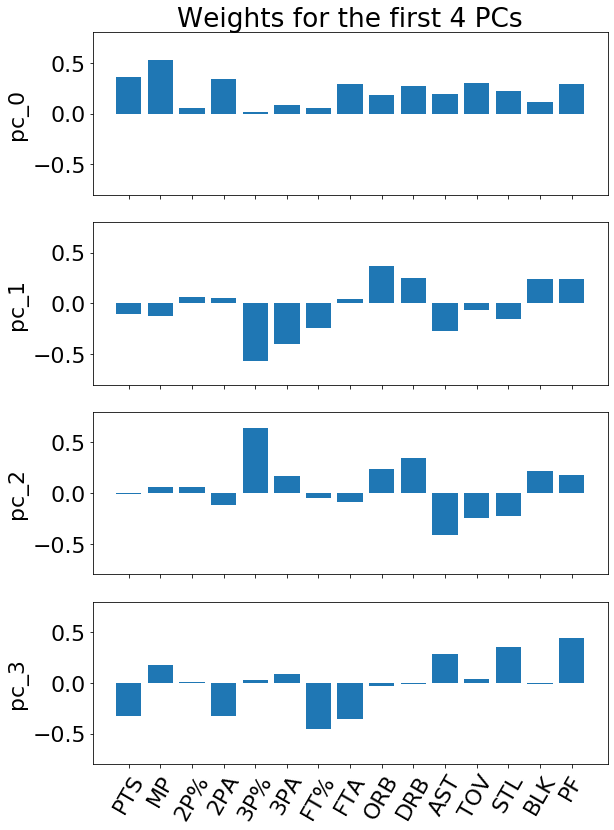

In [13]:
# visualize pca components
plt = plotting.vis_pca(pca, featureList)

# Classification Frequency Over Time
Now that we have each player classified for each season, let's look at how the number of players belonging to each cluster has changed over time.  

In [14]:
# Create the cluster histogram for each season
clusterHist = np.zeros([nSeasons, nClusters])
totPlayers  = np.zeros([nSeasons, nClusters])
for n in range(len(idList)):
    id      = idList[n]
    season  = int(id[-4:])
    cluster = kmeans.labels_[n]
    clusterHist[season-startSeason, cluster] += 1
    totPlayers[season-startSeason,: ]        += 1  
clusterHist = np.divide(clusterHist, totPlayers)

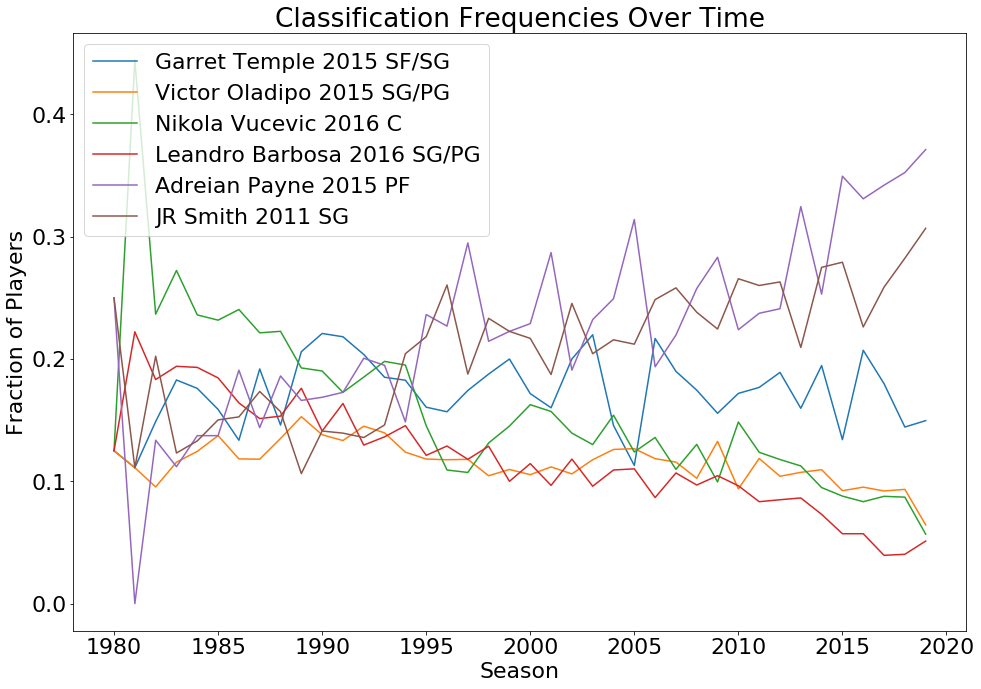

In [15]:
seasonList = range(startSeason, endSeason+1)
for n in range(nClusters):
    plt.plot(seasonList, clusterHist[:,n])
plt.legend(repPlayers)
plt.title("Classification Frequencies Over Time")
plt.ylabel("Fraction of Players")
plt.xlabel("Season");

# The "Most Unique" Players/Seasons
While this question is somewhat abstract, this PCA derived vector space gives us a good chance to measure physically meaningful "distances".    
There are several ways one could imagine of choosing "uniqueness", and I will implement a two.  
To measure distances, each PC will be weighted by the amount of variance it explains and then the distance formula will be applied as usual.  
In all cases, distances will be normalized such that the average measure is 1.

### Points that lie the farthest from the average of all points


3.8283671042648844


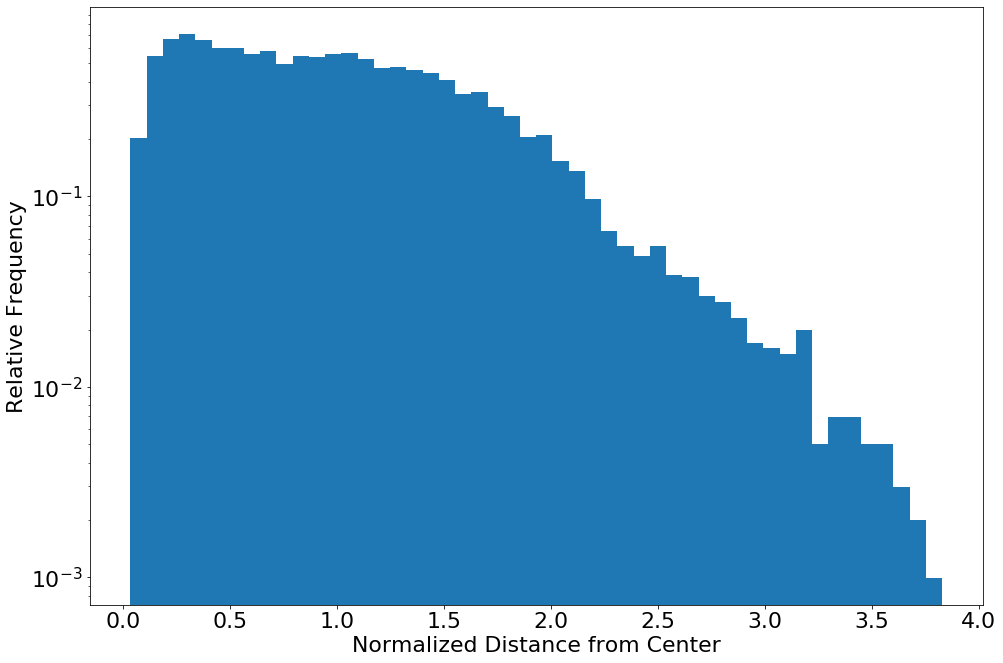

In [64]:
totMean      = np.mean(npDataTrans, axis=0)
weightedData = pca.explained_variance_ratio_[:nFeatures]*npDataTrans
dists        = np.sqrt(np.sum(np.square(weightedData),axis=1))
dists       /= np.mean(dists)
plt.hist(dists, bins=50, log=True, density=True);
plt.xlabel("Normalized Distance from Center");
plt.ylabel("Relative Frequency");

In [73]:
# take a look at who is at the right end of this distribution
sortArgs = np.flip(np.argsort(dists))
rank = 1
for arg in sortArgs[:20]: 
    print(rank, idList[arg], np.round(dists[arg],2))
    rank+=1

1 jordami_1987 3.83
2 jordami_1988 3.74
3 jordami_1989 3.7
4 malonmo_1982 3.67
5 robinda_1994 3.64
6 westbru_2017 3.62
7 hardeja_2019 3.6
8 olajuha_1990 3.6
9 olajuha_1989 3.54
10 onealsh_2001 3.54
11 barklch_1987 3.53
12 olajuha_1993 3.51
13 olajuha_1994 3.49
14 onealsh_2000 3.49
15 malonka_1989 3.48
16 onealsh_1994 3.45
17 barklch_1988 3.43
18 hardeja_2017 3.42
19 olajuha_1995 3.41
20 malonka_1990 3.39


### Points that lie farthest from their cluster center

In [79]:
dists = []
for i in range(nTot):
    center = kmeans.cluster_centers_[kmeans.labels_[i]]
    dists.append(np.sqrt(np.sum(np.square(npDataTrans[i]-center))))
dists  = np.asarray(dists)
dists /= np.mean(dists)

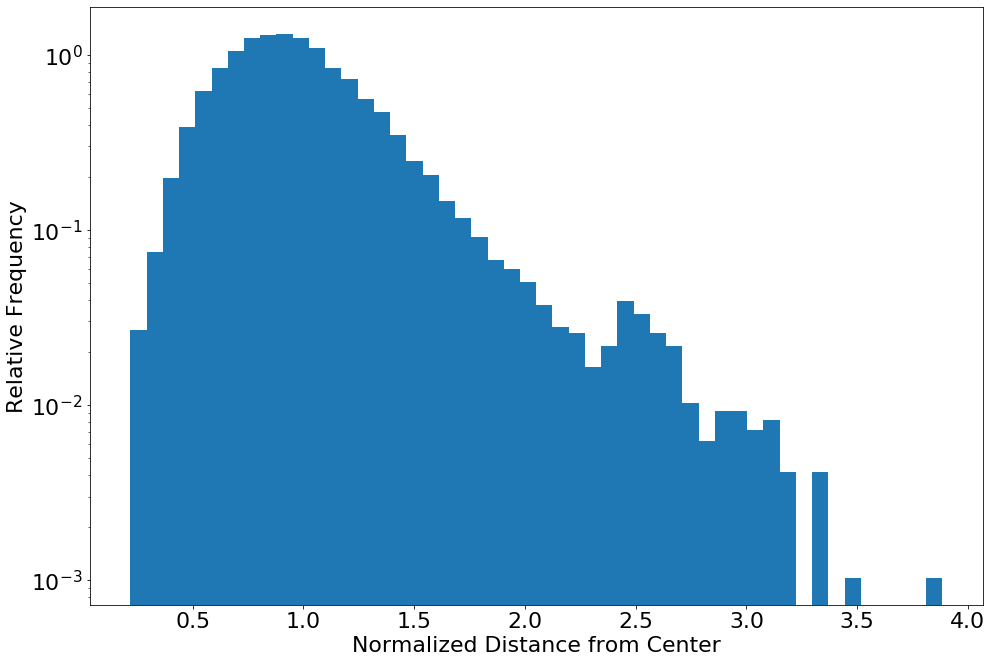

In [80]:
plt.hist(dists, bins=50, log=True, density=True);
plt.xlabel("Normalized Distance from Center");
plt.ylabel("Relative Frequency");

In [81]:
# take a look at who is at the right end of this distribution
sortArgs = np.flip(np.argsort(dists))
rank = 1
for arg in sortArgs[:20]: 
    print(rank, idList[arg], np.round(dists[arg],2))
    rank+=1

1 marticu_1996 3.88
2 polynol_1999 3.46
3 hardeja_2019 3.33
4 jordami_1987 3.33
5 randosh_2009 3.33
6 malonmo_1982 3.31
7 whiteha_2018 3.2
8 bogutan_2016 3.16
9 curryed_2007 3.16
10 willibu_1988 3.16
11 onealsh_2001 3.14
12 brandel_2007 3.1
13 anderer_1994 3.1
14 curryed_2004 3.1
15 onealsh_2000 3.08
16 gilmoar_1982 3.08
17 gortama_2014 3.08
18 bogutan_2013 3.08
19 jacksde_2017 3.05
20 huestjo_2017 3.04
